In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

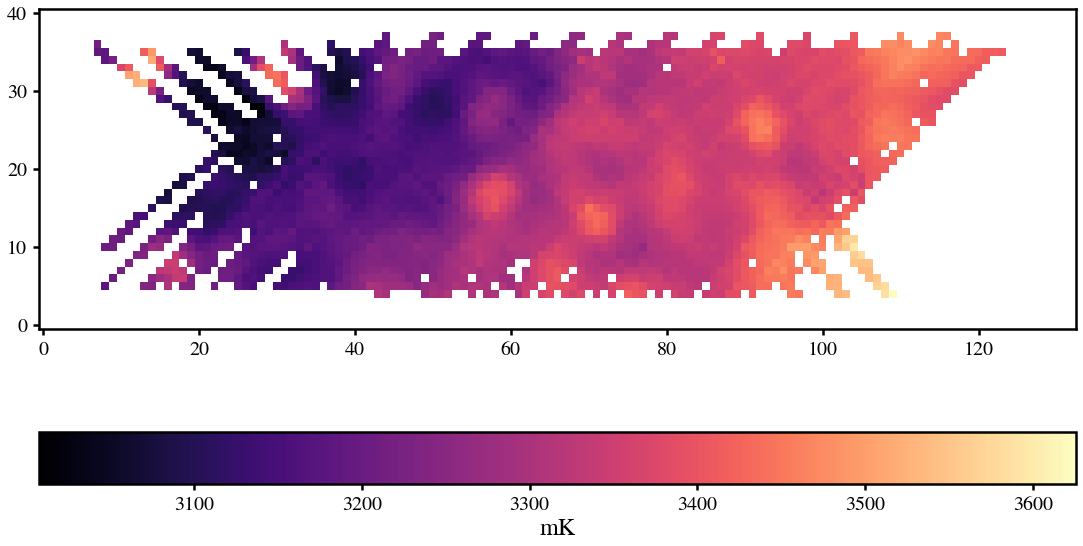

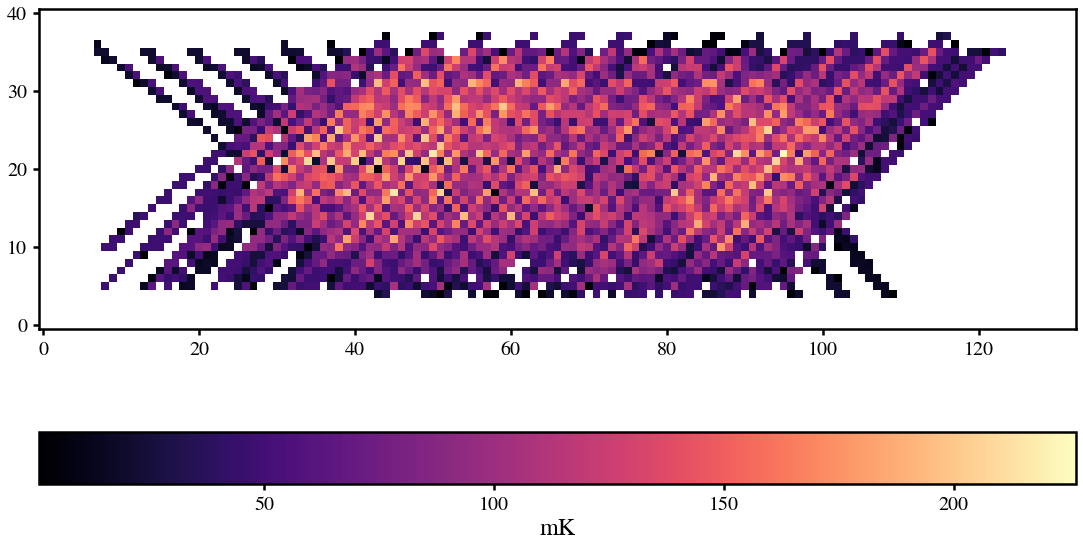

In [8]:
# Read-in level6 MeerKAT data:
# Read-in 2019 MeerKAT data to obtain coordinates:
filestem = '/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p0.3d/p0.3d_sigma2.5_iter2/'
map_file = filestem + 'Nscan366_Tsky_cube_p0.3d_sigma2.5_iter2.fits'
numin,numax = 971,1023.2
dT_MK,w_HI,W_HI,counts,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,numin=numin,numax=numax)
nx,ny,nz = np.shape(dT_MK)

### Remove incomplete LoS pixels from maps:
dT_MK,w_HI,W_HI,counts = Init.FilterIncompleteLoS(dT_MK,w_HI,W_HI,counts)

### IM weights (averaging of counts along LoS so not to increase rank of the map for FG cleaning):
w_HI = np.repeat(np.mean(counts,2)[:, :, np.newaxis], nz, axis=2)

### Plot maps:
plot.Map(dT_MK,W_HI)
plot.Map(w_HI,W_HI)
plt.show()

In [9]:
# Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
from astropy.cosmology import Planck15 as cosmo_astropy
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift - defined as redshift of median frequency
zmin = (nu_21cm/np.max(nu)) - 1 # Effective redshift - defined as redshift of median frequency
zmax = (nu_21cm/np.min(nu)) - 1 # Effective redshift - defined as redshift of median frequency
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
b_HI = 1.5
b_g = np.sqrt(0.83) # for WiggleZ at z_eff=0.41 - from https://arxiv.org/pdf/1104.2948.pdf [pg.9 rhs second quantity]
H0 = cosmo_astropy.H(0).value #km / Mpc s
h = H0/100
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
r = 0.9 # cross-correlation coefficient
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))
d_c = cosmo_astropy.comoving_distance(zeff).value*h # Comoving distance to effective redshift
sig_v = 0
gamma = 1.4 # resmoothing factor - set = None to have no resmoothing
#gamma = None

<Figure size 1296x648 with 0 Axes>

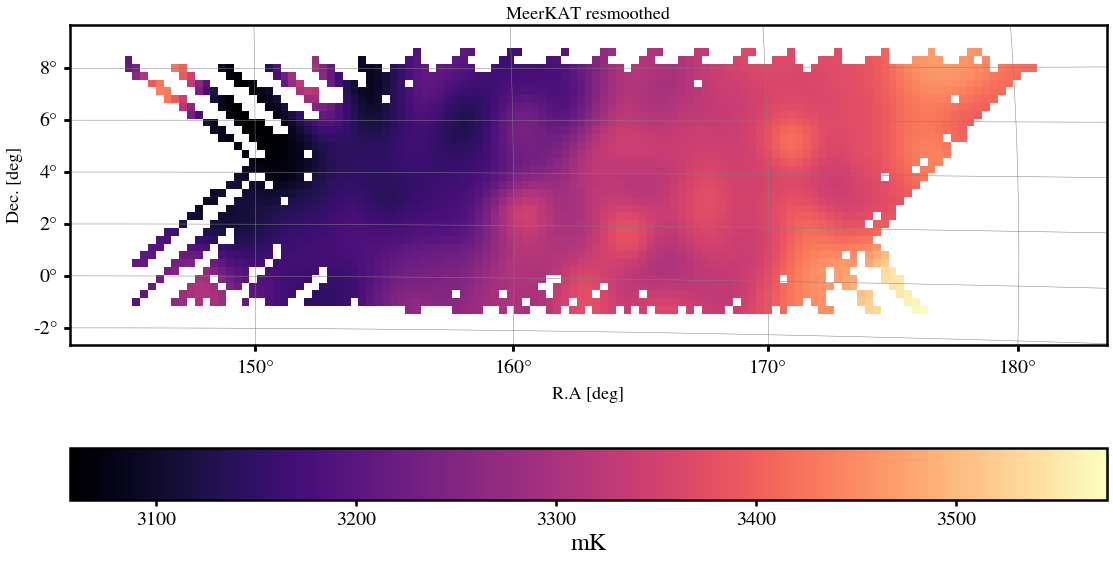

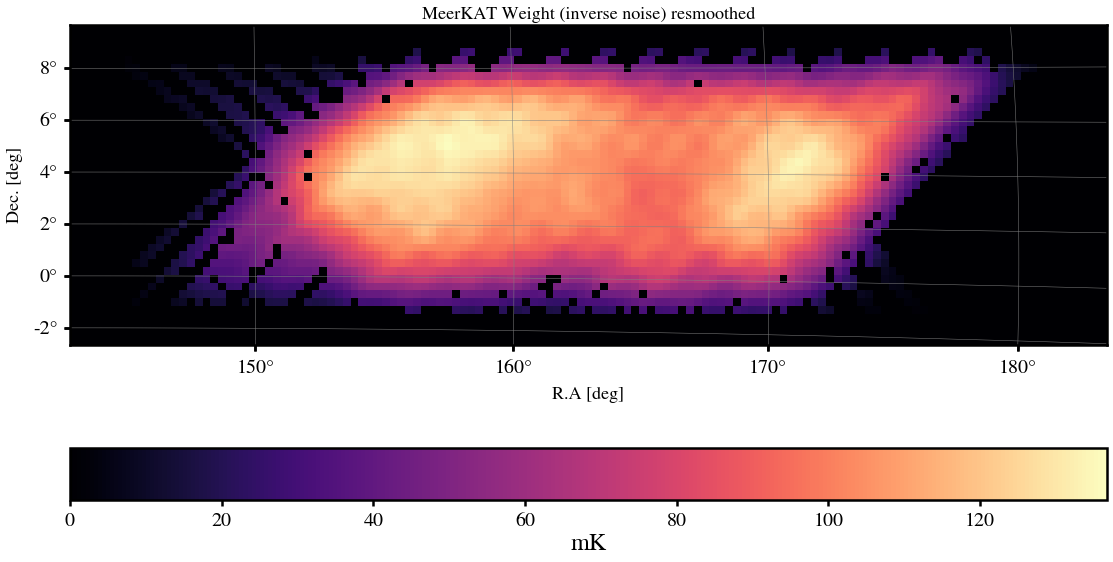

<Figure size 1296x648 with 0 Axes>

In [10]:
import telescope
if gamma is not None:
    dT_MK,w_HI = telescope.weighted_reconvolve(dT_MK,w_HI,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    plot.Map(dT_MK,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
    plot.Map(w_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT Weight (inverse noise) resmoothed')
plt.figure()
#exit()

3995


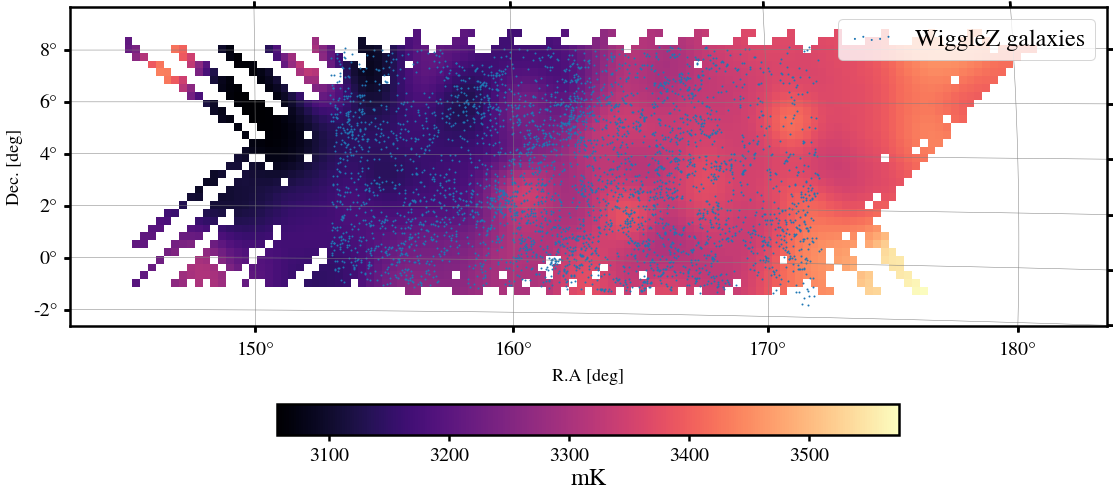

In [11]:
# Read-in WiggleZ galaxies (provided by Laura):
galcat = np.genfromtxt('/users/scunnington/MeerKAT/LauraShare/wigglez_reg11hrS_z0pt30_0pt50/reg11data.dat', skip_header=1)
ra_g,dec_g,z_g = galcat[:,0],galcat[:,1],galcat[:,2]
### Cut redshift to MeerKAT IM range:
zmin,zmax = HItools.Freq2Red(np.max(nu)),HItools.Freq2Red(np.min(nu))
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]

### Cut redshift to MeerKAT IM range:
zmin,zmax = HItools.Freq2Red(np.max(nu)),HItools.Freq2Red(np.min(nu))
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]
print(len(ra_g))

### Plot MK map with overlaid WiggleZ galaxies:
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
plt.grid(True, color='grey', ls='solid',lw=0.5)
img = np.mean(dT_MK,2)
img[np.sum(W_HI,2)==0] = np.nan
plt.imshow(img.T)
cbar = plt.colorbar(orientation='horizontal',shrink=0.6)
cbar.set_label('mK')
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),s=1,label='WiggleZ galaxies',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

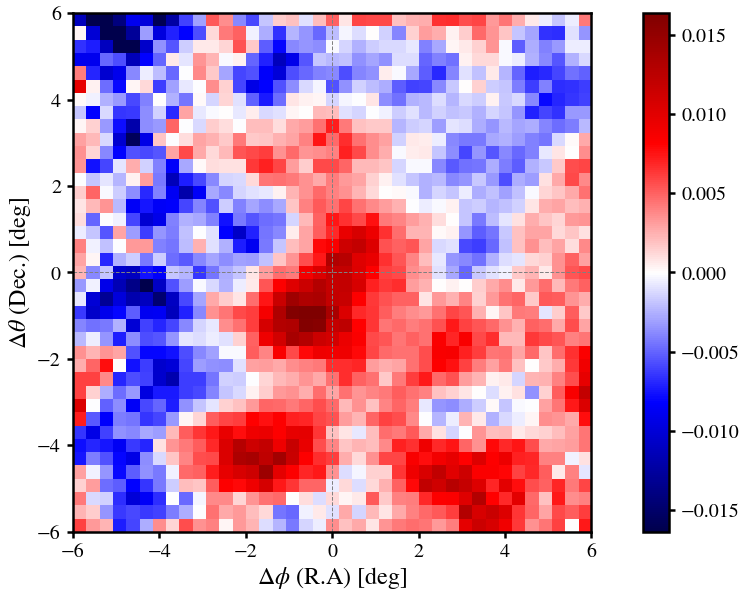

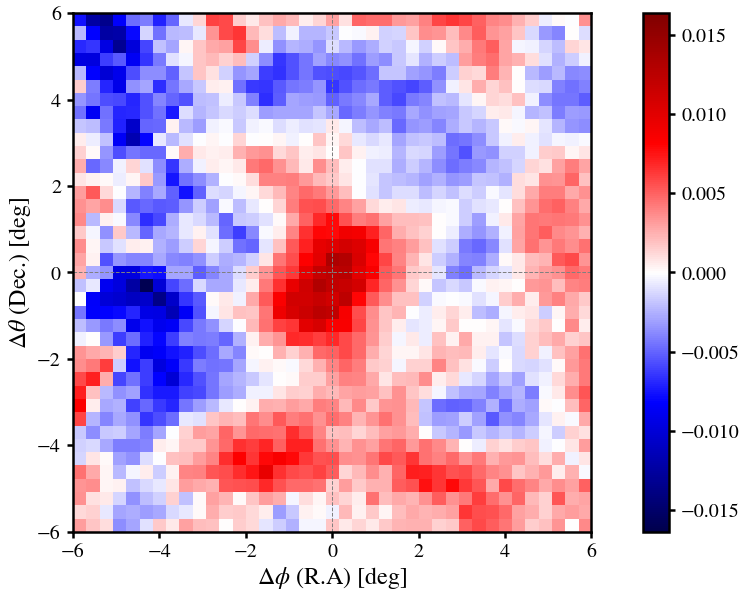

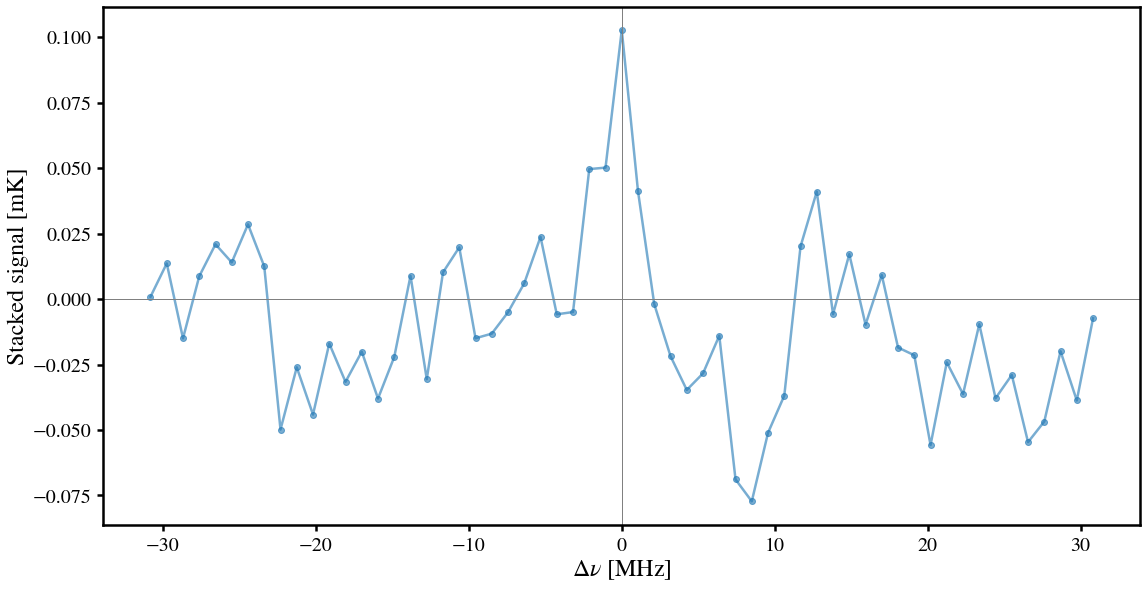

In [20]:
import foreground
N_fg = 10
dT_clean = foreground.PCAclean(dT_MK,N_fg=N_fg,W=W_HI,w=w_HI)

import stack
degmax = 6 # max/min of stacked map [deg]
ddegpix = 0.3 # width of stacked pixels [deg]
ddeg,counts = stack.angular(dT_clean,W_HI,ra_g_cont,dec_g,z_g,ra_cont,dec,nu,degmax,ddegpix,dnu=5,w=None)

plt.imshow(ddeg,extent=[-degmax,degmax,-degmax,degmax],vmin=-np.max(ddeg),vmax=np.max(ddeg),cmap='seismic')
plt.axhline(0,color='gray',ls='--',lw=1)
plt.axvline(0,color='gray',ls='--',lw=1)
plt.xlabel(r'$\Delta\phi$ (R.A) [deg]')
plt.ylabel(r'$\Delta\theta$ (Dec.) [deg]')
plt.colorbar()
#plt.title(r'$N_{\rm fg}=$%s'%N_fg)
plt.show()

N_fg_gama = 10
ddeg_gama,counts_gama = np.load('/idia/projects/hi_im/meerpower/2021Lband/gama/data/stackang_result_Nfg=%s.npy'%N_fg_gama)
ddeg_tot = (ddeg*counts + ddeg_gama*counts_gama) / (counts + counts_gama)
plt.imshow(ddeg_tot,extent=[-degmax,degmax,-degmax,degmax],vmin=-np.max(ddeg),vmax=np.max(ddeg),cmap='seismic')
plt.axhline(0,color='gray',ls='--',lw=1)
plt.axvline(0,color='gray',ls='--',lw=1)
plt.xlabel(r'$\Delta\phi$ (R.A) [deg]')
plt.ylabel(r'$\Delta\theta$ (Dec.) [deg]')
plt.colorbar()
#plt.title(r'$N_{\rm fg}=$%s'%N_fg)
plt.show()

nnu_stack = 150 # +/- nnu_stack channels either side of centred galaxy redshift
nnu_bins = 60 # number of bins
d,nustack_bins = stack.spectral(dT_clean,W_HI,ra_g,dec_g,z_g,ra,dec,nu,nnu_stack,nnu_bins)
plt.plot(nustack_bins,d,'-o',alpha=0.6)
plt.axhline(0,lw=1,color='gray')
plt.axvline(0,lw=1,color='gray')
plt.xlabel(r'$\Delta\nu$ [MHz]')
plt.ylabel('Stacked signal [mK]')
plt.show()
